# Inits

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.prune as prune
import torch.utils.data
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# from sklearn.metrics import confusion_matrix
import json
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cpu = torch.device("cpu")
class network(nn.Module):
    def __init__(self):
        super(network,self).__init__()
        self.conv1 = nn.Conv2d(1,6,3)
        self.conv2 = nn.Conv2d(6,16,3)
        self.fc1 = nn.Linear(16*5*5,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
        self.errors = []
        self.misses = []
    
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,(2,2))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2)
        x = x.view(-1,x.nelement() // x.shape[0]) # nelement/batchsize
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Init network and make a copy into model2

In [3]:
model = network().to(device = device)
model_inits = network()
model_inits.load_state_dict(model.state_dict())

<All keys matched successfully>

In [4]:
torch.set_printoptions(linewidth = 120)
train_set = torchvision.datasets.FashionMNIST(root = '../../data', train = True,  download = True, transform = transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST(root = '../../data', train = False,  download = True, transform = transforms.Compose([transforms.ToTensor()]))

# extract + transform
train_loader = torch.utils.data.DataLoader(train_set,batch_size = 128,pin_memory = True,num_workers=1)
test_loader = torch.utils.data.DataLoader(test_set,batch_size = 128,shuffle=False,pin_memory = True,num_workers=1)
#load

# from torchvision.datasets import MNIST
# transform = transforms.Compose([transforms.ToTensor(), 
#                                         transforms.Normalize((0.5,), (0.5,))])
# dataset = MNIST(root = './data', train = train, transform = transform, download=True)
# train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])


# Utils

In [5]:

def load_net(path,pruned = False):
    model_path = "..\\..\\models\\" + path+".pth"
    loss_path = "..\\..\\models\\" + path + ".json"
    modelloaded = network()
    if pruned:
        prune_iteration(modelloaded)
    state_dict = torch.load(model_path)
    modelloaded.load_state_dict(state_dict, False)
    errors,misses = json.load(open(loss_path, 'r'))
    modelloaded.errors = errors
    modelloaded.misses = misses
    return modelloaded

def save_net(model,path):
    model_path = "..\\..\\models\\" + path+".pth"
    loss_path = "..\\..\\models\\" + path + ".json"
    print(model_path)
    json.dump((model.errors,model.misses),open(loss_path, 'w'))
    torch.save(model.state_dict(),model_path)

In [6]:
def get_num_correct(preds,labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [7]:
def eval_on_test(model,loader):
    missclassif = 0
    running_loss = 0
    for data in loader:
        inputs,labels = data[0].to(device),data[1].to(device)
        outputs = model(inputs)
        wrongs = len(labels) - get_num_correct(outputs,labels)
        missclassif += wrongs
    return missclassif,len(loader.dataset)

# Train Loop

In [8]:
optimizer = optim.Adam(model.parameters(),lr = 0.0005, weight_decay = 0.0002)
loss_function = nn.CrossEntropyLoss()

In [9]:
def train_loop(model,epochs,loader,optimizer,loss_f, converge_check = True, max_downs = -1,new_err_vec = False):
    if max_downs == -1:
        max_downs = epochs
    if new_err_vec:
        model.errors.append([])
        model.misses.append([])
    
    miss_prev = len(loader.dataset)
    miss_classif = 0
    downs = 0
    epoch_loss_prev = 10.0**8
    
    for epoch in range(epochs):
        running_loss = 0
        miss_classif = 0
        epoch_loss = 0.0
        for i,data in enumerate(loader,0):
            inputs,labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_f(outputs,labels)
            loss.backward()
            optimizer.step()
            
            miss_classif += len(labels) - get_num_correct(outputs,labels)
            
            running_loss += loss.item()
            epoch_loss += loss.item()
#             if i % 100 == 99:
#                 print('[%d, %5d] loss: %.3f' %
#                       (epoch + 1, i + 1, running_loss / train_loader.batch_size))
#                 running_loss = 0
        
        print("Epoch %d done with total %d misses \n and error %f\n"%(epoch,miss_classif,epoch_loss))
        epoch_loss_prev = epoch_loss
        model.errors[-1].append(epoch_loss)
        model.misses[-1].append(miss_classif)
        if (epoch_loss > epoch_loss_prev) and convergence_check:
            downs +=1
            if downs > max_downs:
                print("Converged. %d losses were bigger"%(max_downs))
                return
        miss_prev = miss_classif
    print("Done!")

In [ ]:
train_loop(model,130,train_loader,optimizer,loss_function, new_err_vec= True)

# Saving

In [10]:
eval_on_test(model,test_loader)

(9000, 10000)

In [ ]:
save_net(model, "fashion_trained")
save_net(model_inits, "fashion_init")

# Loaded model

In [ ]:
model= load_net("fashion_pruned",True).to(device)
# eval_on_test(model,test_loader)

In [ ]:
# plt.plot(np.array(model2.errors[0][15:])/60000)

In [ ]:
# !jupyter nbconvert --to script pruning.ipynb

In [ ]:
# l = [0,2,3,4,5]
# model2.conv1.bias  =  torch.nn.Parameter(model2.conv1.bias[l].clone())
# model2.conv1.weight = torch.nn.Parameter(model2.conv1.weight[l].clone())
# model2.conv2.weight= torch.nn.Parameter(model2.conv2.weight[:,l,:].clone())
# model2.conv2.bias= torch.nn.Parameter(model2.conv2.bias[:,l,:].clone())

# Pruning

In [11]:
def countZeroWeights(model):
    zeros = 0
    for param in model.buffers():
        if param is not None:
            zeros += param.numel() - param.nonzero().size(0)
    return zeros

In [12]:
sum(p.numel() for p in model.parameters())

60074

In [15]:
model = load_net("fashion_pruned",True).to(device)
optimizer = optim.Adam(model.parameters(), weight_decay = 0.001)
# optimizer = optim.Adam(model.parameters(),lr = 0.0005, weight_decay = 0.0002)

In [14]:
def prune_iteration(model,p = [1,2,0.2,0.2,0.2]):
    prune.ln_structured(model.conv1, name = "weight", amount = p[0], n =1, dim = 0)
    prune.ln_structured(model.conv2, name = "weight", amount = p[1], n = 1, dim= 0)
    prune.ln_structured(model.fc1, name = "weight", amount = p[2], n=1, dim = 0)
    prune.ln_structured(model.fc2, name = "weight", amount = p[3], n=1, dim = 0)
#     prune.ln_structured(model.fc3, name = "weight", amount = p[4], n=1, dim = 0)
def prune_train_iteration(model,epochs,loader,optimizer,loss_f, converge_check = True, max_downs = -1, p =[1,2,0.2,0.2,0.2]):
    prune_iteration(model, p)
    train_loop(model, epochs, loader,optimizer,loss_f)

In [21]:
prune_train_iteration(model, 40, train_loader, optimizer, loss_function, p = [0,0,0.2,0.2,0.2])


Epoch 0 done with total 5501 misses 
 and error 115.851992

Epoch 1 done with total 5057 misses 
 and error 106.255768

Epoch 2 done with total 4937 misses 
 and error 103.576696

Epoch 3 done with total 4855 misses 
 and error 102.253876

Epoch 4 done with total 4780 misses 
 and error 101.032604

Epoch 5 done with total 4747 misses 
 and error 100.346748

Epoch 6 done with total 4706 misses 
 and error 99.532030

Epoch 7 done with total 4670 misses 
 and error 98.838744

Epoch 8 done with total 4605 misses 
 and error 98.337227

Epoch 9 done with total 4619 misses 
 and error 98.028558

Epoch 10 done with total 4543 misses 
 and error 97.402126

Epoch 11 done with total 4580 misses 
 and error 97.406880

Epoch 12 done with total 4549 misses 
 and error 96.777458

Epoch 13 done with total 4529 misses 
 and error 96.531275

Epoch 14 done with total 4523 misses 
 and error 96.224090

Epoch 15 done with total 4489 misses 
 and error 95.815779

Epoch 16 done with total 4498 misses 
 and e

In [ ]:
train_loop(model, 50, train_loader,optimizer,loss_function,converge_check = True, max_downs = -1)

In [22]:
eval_on_test(model,test_loader)

(1265, 10000)

In [24]:
save_net(model,"fashion_pruned_meh")

..\..\models\fashion_pruned_meh.pth


In [23]:
countZeroWeights(model)

39245

# Loading networks

In [27]:
model2 = load_net("fashion_pruned_meh",True)
model2.to(device)

network(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [28]:
eval_on_test(model2,test_loader)
# model2.conv1._forward_pre_hooks

(1265, 10000)

In [ ]:
# list(model.conv1.named_parameters())
(model.conv1.weight_orig).data.clone()

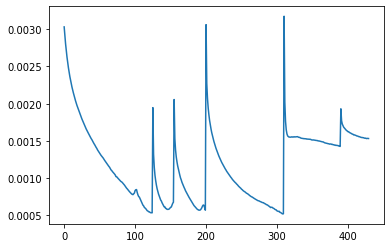

In [87]:
plt.plot(np.array(model.errors[0][5:])/60000)

# Lottery Ticket

In [76]:
def init_ticket(init_path, pruned_path):
    init_net = load_net(init_path)
    ticket = load_net(pruned_path,True)
    with torch.no_grad():
        pruned_module_list = list(ticket.named_parameters())
        init_module_list = list(init_net.named_parameters())
        print(len(pruned_module_list))
        for i in range(1,len(pruned_module_list) -2, 2):
            print(pruned_module_list[i][0], init_module_list[i-1][0])
            pruned_module_list[i][1].data = init_module_list[i-1][1].data.clone()

        for i in range(0,len(pruned_module_list) -3, 2):
            print(pruned_module_list[i][0], init_module_list[i+1][0])
            pruned_module_list[i][1].data = init_module_list[i+1][1].data.clone()
        ticket.fc3.weight.data = init_net.fc3.weight.data.clone()
        ticket.fc3.bias.data = init_net.fc3.bias.data.clone()
        
        print()
        
    return ticket

In [77]:
ticket = init_ticket("fashion_init","fashion_pruned").to(device)

10
conv1.weight_orig conv1.weight
conv2.weight_orig conv2.weight
fc1.weight_orig fc1.weight
fc2.weight_orig fc2.weight
conv1.bias conv1.bias
conv2.bias conv2.bias
fc1.bias fc1.bias
fc2.bias fc2.bias



In [86]:
eval_on_test(ticket,test_loader)

(1162, 10000)

In [79]:
optimizer = optim.Adam(ticket.parameters(),lr = 0.0005, weight_decay = 0.0002)
loss_function = nn.CrossEntropyLoss()

In [85]:
train_loop(ticket,30,train_loader,optimizer,loss_function)

Epoch 0 done with total 6578 misses 
 and error 139.491269

Epoch 1 done with total 6536 misses 
 and error 138.739862

Epoch 2 done with total 6512 misses 
 and error 138.011942

Epoch 3 done with total 6480 misses 
 and error 137.228211

Epoch 4 done with total 6431 misses 
 and error 136.407698

Epoch 5 done with total 6405 misses 
 and error 135.703799

Epoch 6 done with total 6386 misses 
 and error 135.040605

Epoch 7 done with total 6347 misses 
 and error 134.354978

Epoch 8 done with total 6330 misses 
 and error 133.685360

Epoch 9 done with total 6301 misses 
 and error 133.065835

Epoch 10 done with total 6267 misses 
 and error 132.422193

Epoch 11 done with total 6245 misses 
 and error 131.833328

Epoch 12 done with total 6233 misses 
 and error 131.220677

Epoch 13 done with total 6193 misses 
 and error 130.634897

Epoch 14 done with total 6167 misses 
 and error 130.040356

Epoch 15 done with total 6120 misses 
 and error 129.448363

Epoch 16 done with total 6098 miss

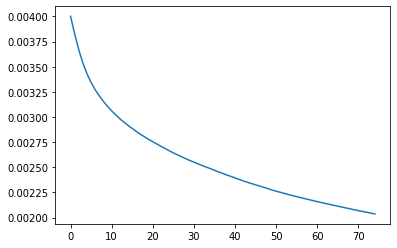

In [90]:
plt.plot(np.array(ticket.errors[1][5:])/60000)

In [96]:
unpruned_model = load_net("fashion_trained").to(device)
pruned_model = load_net("fashion_pruned",True).to(device)

In [97]:
print(eval_on_test(ticket,test_loader))
print(eval_on_test(unpruned_model,test_loader))
print(eval_on_test(pruned_model,test_loader))

(1162, 10000)
(1222, 10000)
(1183, 10000)


In [101]:
len(ticket.errors[1])

80

In [103]:
save_net(ticket,"ticket")

..\..\models\ticket.pth


In [106]:
tk  = load_net("ticket",True).to(device)
eval_on_test(tk,test_loader)

(1162, 10000)